Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

- [2024/02/05]    
  `%load_ext` and `%autoreload` magic commands avoid restarting this notebook
  when you change the scratch library.   
  A new library in this notebook that needs to install: `scipy`

- [2024/02/11]   
  I suggest myself in the future to read (Agresti et al., 2023) - Statistics   
  Chapter 8 and 9 before reading this notebook.

In [4]:
import enum
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
from scipy import special as sc_special
from collections import Counter

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})


## Dependence and Independence Events

We say that two events $E$ and $F$ are *dependent* if knowing something   
about whether $E$ happens gives us information about whether $F$
happens (and vice versa).   
Otherwise, the are *independent*

Mathematically, we say that two events $E$ and $F$ are independent   
if the probability that **they both happen** is the product of
the probabilities that each one happens:

$$
  P(E, F) = P(E) P(F)
$$

## Conditional Probability

If two events $E$ and $F$ are not necessarily independent (and if the   
probability of $F$ is not zero), then we can define the probability of
$E$ "conditional on $F$" as:

$$
  P(E|F) = \frac{P(E,F)}{P(F)}
$$

When $E$ and $F$ are independent, we have
$$
\begin{align*}
  P(E|F) &= \frac{P(E,F)}{P(F)} \\ 
         &= \frac{P(E) P(F)}{P(F)} \\
         &= P(E)
\end{align*}
$$
which is the mathematical way of expressing that knowing $F$ occurred gives  
us no additional information whether $E$ occurrred.

### Example: a family with two (unknown) children

Assumption:
- Each child is equally likely to be a boy or a girl.
- The gender of the second child is independent of the gender
  of the first child.

In [6]:
table = [
  ["boy", "girl"],
  ["boy", "(boy, boy)", "(boy, girl)"],
  ["girl", "(girl, boy)", "(girl, girl)"]]

print(f"Possible outcomes")
print(tabulate(table, headers="firstrow", tablefmt="simple"))

Possible outcomes
      boy          girl
----  -----------  ------------
boy   (boy, boy)   (boy, girl)
girl  (girl, boy)  (girl, girl)


- What is the probability of the event "both children are girls" ($B$)  
  conditonal on the event "the older child is girl" ($G$).

  $$
    P(B|G) = \frac{P(B, G)}{P(G)} = \frac{P(B)}{P(G)}
           = \frac{1/4}{1/2} = \frac{1}{2}
  $$

  since the event $B$ and $G$ ("both children are girls *and* the older
  child is girl") is just the event $B$.   
  (Once you know that both children
  are girls, it's necessarily true that the older child is a girl)

- What is the probability of the event "both children are girls" ($B$)
  conditional on the event "at least one of the children is a girl" ($L$)

  $$
    P(B|L) = \frac{P(B, L)}{P(L)} = \frac{P(B)}{P(L)}
           = \frac{1/4}{3/4} = \frac{1}{3}
  $$

We can also simulate the above questions using the following script

In [7]:
# An enum is a typed set of enumerated values.
# We can use them to make our code more descriptive
# and readable.

class Kid(enum.Enum):
  BOY = 0;
  GIRL = 1;

def random_kid(rng) -> Kid:
  return rng.choice([Kid.BOY, Kid.GIRL])

In [8]:
Kid.BOY

<Kid.BOY: 0>

In [17]:
# rnd_seed = 2023_03_09
rnd_seed = None
rng = np.random.default_rng(rnd_seed)

both_girls = 0
older_girl = 0
either_girl = 0

for _ in range(10_000):   # generate 10_000 pairs of children
  younger = random_kid(rng)
  older = random_kid(rng)

  if older == Kid.GIRL:
    older_girl += 1
  if older == Kid.GIRL and younger == Kid.GIRL:
    both_girls += 1
  if older == Kid.GIRL or younger == Kid.GIRL:  # at least one girl
    either_girl += 1

print(f"P(both | older): {both_girls / older_girl}")      # 0.514 ~ 1/2
print(f"P(both | either): {both_girls / either_girl}")    # 0.342 ~ 1/3


P(both | older): 0.49173471420035847
P(both | either): 0.3324357075535209


## Bayes's Theorem

> Note: If you want to get the three level of understanding:
> - (easy) The meaning of its terms,
> - (medium) Why is it true (how to derive the formula)
> - (hard) When do we use that formula? 
> Please watch 3Blue1Brown video: [Bayes theorem, the geometry of changing beliefs](https://www.youtube.com/watch?v=HZGCoVF3YvM).
> The idea of Bayes's theorem is, when you have an hypothesis and you get
> a new information about the evidence. This evidence does not completely
> change your believe, but update your believe.
> Probability is all about the ratio.

We can think this theorem as a way of "reversing" conditional probabilities.

Using the definition of conditional probability twice, we have the following Bayes' theorem:

$$
  P(E|F) = \frac{P(E,F)}{P(F)}
         = \frac{P(F|E) P(E)}{P(F)}
$$

We can rewrite the above formulation without $P(F)$.   
The event $F$ can be split into two mutually exclusive events 
(see [Kolmogorov axioms: $\sigma$-additivity](https://en.wikipedia.org/wiki/Probability_axioms)):    
"$F$ and $E$" and "$F$ and not $E$".   
Using the notation $\neg E$ for "not $E$" (i.e., "$E$ doesn't happen"), then

$$
  P(F) = P(F, E) + P(F, \neg E)
$$

so that:

$$
\begin{align*}
  P(E|F) &= \frac{P(F|E) P(E)}{P(F)}
         = \frac{P(F|E) P(E)}{P(F, E) + P(F, \neg E)} \\
         &= \frac{P(F|E) P(E)}{P(F|E) P(E) + P(F|\neg E) P(\neg E)}
\end{align*}
$$
in the last step, we use the definition of conditional probability

### Example: Test positive and disease

Imagine a certain disease that affects 1 in every 10,000 people.  
And imagine that there is a test for this disease that gives the correct  
result ("diseased" if you have the disease, "nondiseased" if you don't)
99% of the time.

What does a positive test meant?

Let's use $T$ for the event "your test is positive"    
and $D$ for the event "you have the disease." Then Bayes's theorem
says that the probability that you have the disease, condtional on
testing positive, is:

$$
  P(D|T) = \frac{P(T|D) P(D)}{P(T|D) P(D) + P(T|\neg D) P(\neg D)}
$$

- $P(T|D)$ is the probability that someone with the disease test positive
  (99% = 0.99)
- $P(D)$ is the probability that any given person has the disease
  (1/10,000 = 0.0001)
- $P(T|\neg D)$ is the probability that someone without the disease
  tests positive (100% - 99% = 1% = 0.01)
- $P(\neg D)$ is the probability that any given person doesn't have the
  disease ((10,000-1)/10,000 = 0.9999)

Substitute the numbers into Bayes's theorem, we find

$$
  P(D|T) = \frac{(0.99) \,(0.0001)}{(0.99)\,(0.0001) + (0.01)\,(0.9999)} 
         \approx 0.0098
         = 0.98\%
$$

That is, less than 1% of the people who test positive actually have
the disease.

In [19]:
print((0.99 * 0.0001)/ (0.99 * 0.0001 + 0.01 *0.9999))

99/(99 + 9999)

0.00980392156862745


0.00980392156862745

The test result is quite low right!. This is called "veredicial paradox"
(it is correct, but it seems false). Our accuracy does not implies predictivity.

Fortunately, 3Blue1Brown makes a nice video about it: [The medical test paradox, and redesigning Bayes' rule](https://www.youtube.com/watch?v=lG4VkPoG3ko)

Short answer: $P(T|D)$ is the probability of someone with disease test positive.
We start from the prior distribution ($P(D)$) the probability that someone with disease.
After the test, we update our belief and it also change the distribution
into posterior distribution: $P(D|T)$ someone who take the test and actually have disease

<img src="./img-resources/bayes-theorem-disease.drawio.png" width=600></img>

Before test
$$
  \frac{\text{\color{pink}\# with disease}}{\text{\# without disease}}
  = \frac{\color{pink}10}{90}
$$

After test
$$
  \frac{\text{\color{pink}\# with disease}\cdot \color{pink}P(+|\text{disease})}{
    \text{\# without disease}\cdot P(+|\text{without disease})}
    = \frac{10 \cdot \frac{9}{10}}{90 \cdot \frac{9}{90}}
    = 1
$$

The right hand side results are the odd. This means that the number of the
people who have disease and get the positive results are equal to the 
number of people who do not have disease and get the positive result

Apply this procedure, to the previous problem:
$$
\frac{\text{\# with disease} \cdot P(+|\text{disease})}{
  \text{\# without disease} \cdot P(+|\text{without disease})} 
  = \frac{\text{\# with disease} \cdot P(T,D)}{\text{\# without disease} \cdot P(T, \neg D)} 
  = \frac{1}{9\,999} \frac{99\%}{1\%}
  = \frac{99}{9\,999}
$$

The result is the ratio between the number of people who has diseases
given the positive test result and the number of people who has not diseases
given the positive test result. To achieve the same result using Bayes's rule
(probability form), we change from odd to probability form
$$
  P(D, T) = \frac{99}{99 + 9\,999} \approx 0.0098 = 0.98\%
$$

## Random Variables

A *random variable* is a variable whose possible values have an associated
probability distribution.    
An *expected value* of a random variable is the average of its values
weighted by their probabilities.

## Continuous Distributions

In [20]:
def uniform_pdf(x: float) -> float:
  return 1 if 0 <= x < 1 else 0

def uniform_cdf(x: float) -> float:
  """Returns the probability that a uniform random variable is <= x"""
  if x < 0:
    return 0      # uniform random is never less than 0
  elif x < 1:
    return x      # e.g. P(X <= 0.4) = 0.4
  else:
    return 1      # uniform random is always less than 1

The probability density function of uniform distribution
$$
  f(x) = \left\{
    \begin{align*}
      &\frac{1}{b - a} &\quad \text{for } x \in [a, b] \\
      &0                &\quad \text{otherwise}
    \end{align*}
  \right.
$$

The cumulative density function of uniform distribution
$$
  F(x) = \left\{
    \begin{align*}
      &0                    &\quad \text{for } x < a \\
      &\frac{x - a}{b - a}  &\quad \text{for } x \in [a, b] \\
      &1                    &\quad \text{for } x > b
    \end{align*}
  \right. 
$$

The inverse of cumulative density function of uniform distribution
$$
  F^{-1}(p) = a + p(b -a) \quad \text{for } 0 < p 1
$$

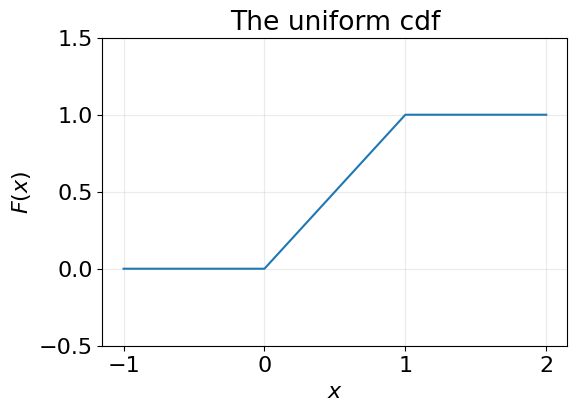

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

xs = np.linspace(-1, 2, 100)

ax.plot(xs, [uniform_cdf(x) for x in xs], )

ax.set_ylim([-0.5, 1.5])
ax.set_xlabel("$x$")
ax.set_ylabel(r"$F(x)$")
ax.set_title(f"The uniform cdf")

ax.grid("on")
plt.show(fig)


## The Normal Distributions

probability density function
$$
  f(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi}\, \sigma}
                    \exp\left(- \frac{(x-\mu)^2}{2\sigma^2}\right)
$$

cumulative density function
$$
  F(x|\mu, \sigma) = \frac{1}{2} \left[ 
      1 + \operatorname{erf}\left(\frac{x - \mu}{\sigma\sqrt{2}}\right) 
    \right]
$$

inverse of cummulative density function
$$
  F^{-1}(p|\mu, \sigma) = 
    \mu + \sigma \sqrt(2) \operatorname{erf}^{(-1)} (2p - 1), 
    \quad p \in (0, 1)
$$

If $Z$ is a standard normal random variable (mean = 0, std = 1), then it turns out that:
$$
  X = \sigma Z + \mu
$$
is also normal but with mean $\mu$ and standard deviation $\sigma$

In [22]:
def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
  return (1/(np.sqrt(2*np.pi) * sigma)) \
    * np.exp(-(x - mu)**2 / (2*sigma**2))

In [23]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
  return 0.5 * (1 + sc_special.erf((x - mu) / (sigma * np.sqrt(2))))

In [24]:
def inverse_normal_cdf(p: float, mu: float = 0, sigma: float = 1, 
  tolerance: float = 1e-5) -> float:

  """Find approximate inverse using binary search"""

  # if not standard, compute standard and rescale
  if abs(mu) > 1e-5 or abs(sigma - 1) > 1e-5:
    return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

  low_z = -10.0         # normal_cdf(-10) is (very close to) 0
  high_z = 10.0         # normal_cdf(10) is (very close to) 1

  while high_z - low_z > tolerance:
    mid_z = (low_z + high_z) / 2      # Consider the midpoint
    mid_p = normal_cdf(mid_z)         # and the CDF's value there
    if mid_p < p:
      low_z = mid_z                   # Midpoint too low search above it
    else:
      high_z = mid_z                  # Midpoint to high, search below it

  return mid_z

def inverse_normal_cdf_with_scipy(
  p: float, mu: float = 0, sigma: float = 1) -> float:

  return mu + sigma * np.sqrt(2) * sc_special.erfinv(2*p - 1)

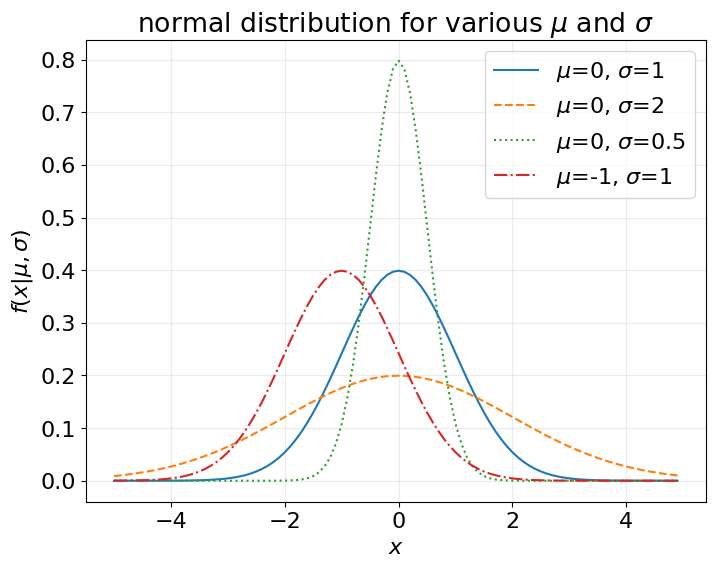

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

xs = [x / 10.0 for x in range(-50, 50)]

ax.plot(xs, [normal_pdf(x, sigma=1) for x in xs],
  '-', label=r"$\mu$=0, $\sigma$=1")
ax.plot(xs, [normal_pdf(x, sigma=2) for x in xs],
  '--', label=r"$\mu$=0, $\sigma$=2")
ax.plot(xs, [normal_pdf(x, sigma=0.5) for x in xs],
  ':', label=r"$\mu$=0, $\sigma$=0.5")
ax.plot(xs, [normal_pdf(x, mu=-1) for x in xs],
  "-.", label=r"$\mu$=-1, $\sigma$=1")

ax.set_xlabel("$x$")
ax.set_ylabel(r"$f(x|\mu,\sigma)$")
ax.set_title(f"normal distribution for various $\mu$ and $\sigma$")

ax.grid("on")
ax.legend(loc="best")
plt.show(fig)

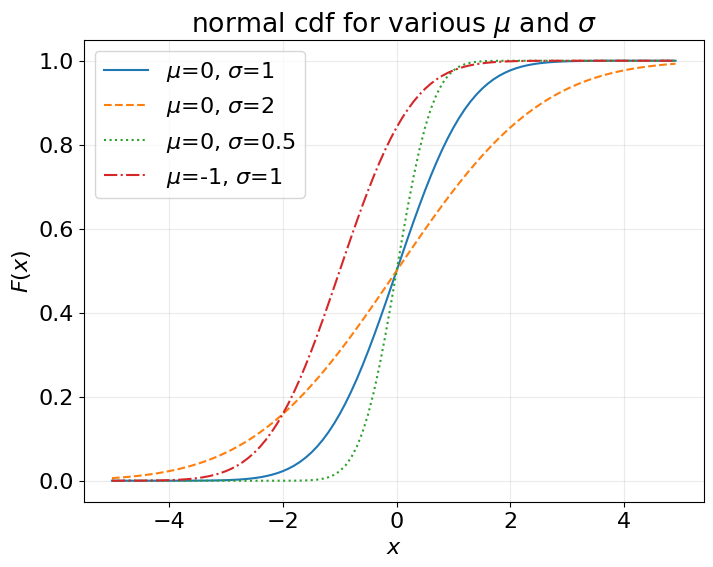

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

xs = [x / 10.0 for x in range(-50, 50)]

ax.plot(xs, [normal_cdf(x, sigma=1) for x in xs],
  '-', label=r"$\mu$=0, $\sigma$=1")
ax.plot(xs, [normal_cdf(x, sigma=2) for x in xs],
  '--', label=r"$\mu$=0, $\sigma$=2")
ax.plot(xs, [normal_cdf(x, sigma=0.5) for x in xs],
  ':', label=r"$\mu$=0, $\sigma$=0.5")
ax.plot(xs, [normal_cdf(x, mu=-1) for x in xs],
  "-.", label=r"$\mu$=-1, $\sigma$=1")

ax.set_xlabel("$x$")
ax.set_ylabel("$F(x)$")
ax.set_title(f"normal cdf for various $\mu$ and $\sigma$")

ax.grid("on")
ax.legend(loc="best")
plt.show(fig)

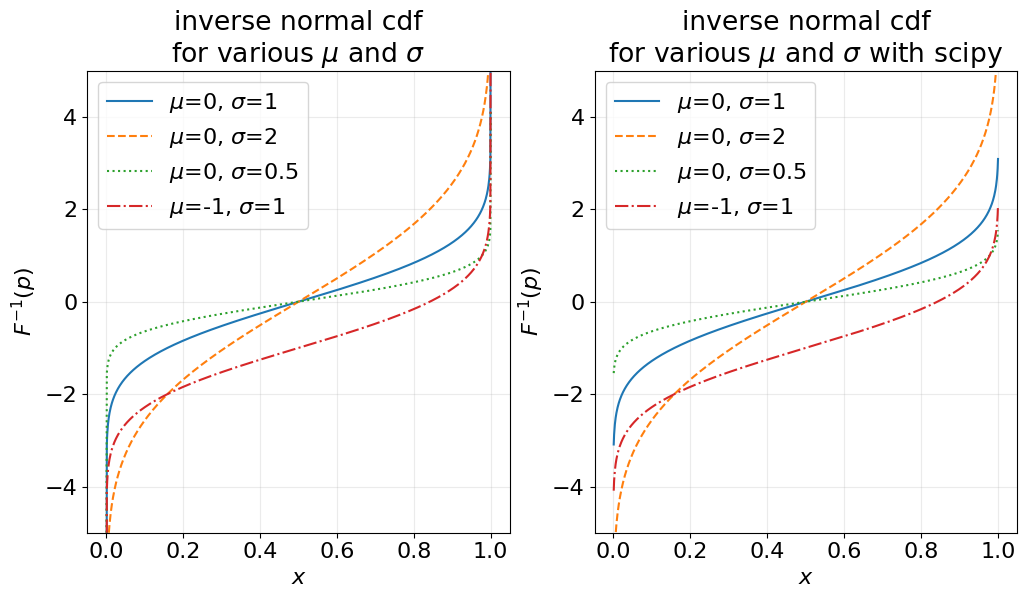

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

xs = np.linspace(0, 1, 1000)

axes[0].plot(xs, [inverse_normal_cdf(p, sigma=1) for p in xs],
  '-', label=r"$\mu$=0, $\sigma$=1")
axes[0].plot(xs, [inverse_normal_cdf(p, sigma=2) for p in xs],
  '--', label=r"$\mu$=0, $\sigma$=2")
axes[0].plot(xs, [inverse_normal_cdf(p, sigma=0.5) for p in xs],
  ':', label=r"$\mu$=0, $\sigma$=0.5")
axes[0].plot(xs, [inverse_normal_cdf(p, mu=-1) for p in xs],
  "-.", label=r"$\mu$=-1, $\sigma$=1")

axes[0].set_xlabel("$x$")
axes[0].set_ylabel(r"$F^{-1}(p)$")
# ax.set_yscale("symlog")
axes[0].set_ylim([-5, 5])
axes[0].set_title(f"inverse normal cdf\nfor various $\mu$ and $\sigma$")

axes[0].grid("on")
axes[0].legend(loc="best")


axes[1].plot(xs, [inverse_normal_cdf_with_scipy(p, sigma=1) for p in xs],
  '-', label=r"$\mu$=0, $\sigma$=1")
axes[1].plot(xs, [inverse_normal_cdf_with_scipy(p, sigma=2) for p in xs],
  '--', label=r"$\mu$=0, $\sigma$=2")
axes[1].plot(xs, [inverse_normal_cdf_with_scipy(p, sigma=0.5) for p in xs],
  ':', label=r"$\mu$=0, $\sigma$=0.5")
axes[1].plot(xs, [inverse_normal_cdf_with_scipy(p, mu=-1) for p in xs],
  "-.", label=r"$\mu$=-1, $\sigma$=1")

axes[1].set_xlabel("$x$")
axes[1].set_ylabel(r"$F^{-1}(p)$")
# ax.set_yscale("symlog")
axes[1].set_ylim([-5, 5])
axes[1].set_title(f"inverse normal cdf\nfor various $\mu$ and $\sigma$ with scipy")

axes[1].grid("on")
axes[1].legend(loc="best")


plt.show(fig)


## The Central Limit Theorem

A random variable defined as the average of a large number
of independent and identically distributed random variables
is itself approximately normally distributed

In [28]:
def bernoulli_trial(p: float, rng) -> int:
  """Returns 1 with probability p and 0 with probability 1-p""" 
  return 1 if rng.random() < p else 0 

In [29]:
def binomial(n: int, p: float, rng) -> int:
  """Returns the sum of n bernoulli(p) trials""" 
  return sum(bernoulli_trial(p, rng) for _ in range(n))

In [30]:
def binomial_histogram(p: float, n: int, num_points: int, rng) -> None:
  """Picks points from a binomial(n, p) and plots their histogram""" 
  data = [binomial(n, p, rng) for _ in range(num_points)]

  fig, ax = plt.subplots(figsize=(8, 6))

  histogram = Counter(data)
  ax.bar(
    [x  for x in histogram.keys()],
    [v / num_points for v in histogram.values()],
    0.8, color='0.75', label=None
  )

  mu = p * n 
  sigma = np.sqrt(n * p * (1 - p))

  # use a line chart to show the normal approximation
  xs = np.linspace(min(data), max(data), 200)
  ys = [normal_pdf(i, mu, sigma) for i in xs]
  
  ax.plot(xs, ys, label="normal dist.")

  ax.set_xlabel("x")
  ax.set_title("Binomial dist. vs. normal approx.")
  ax.grid("on")
  ax.legend(loc="best")

  plt.show(fig)

  return None

### Comparison between binomial distribution and normal distribution

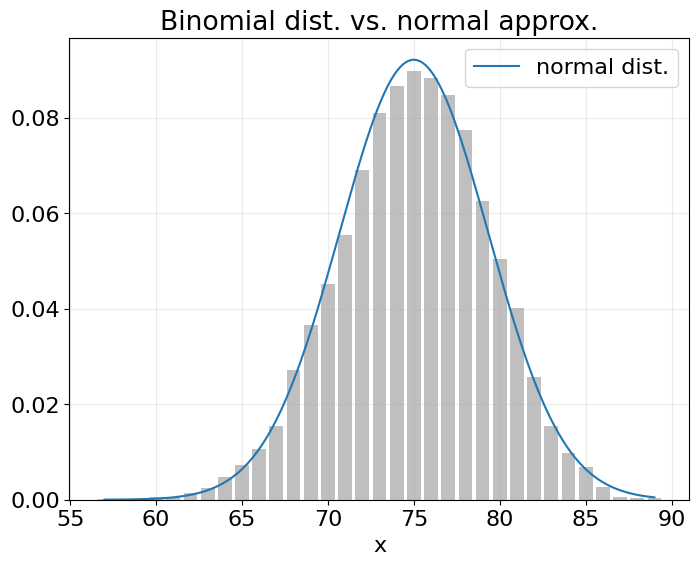

In [31]:
p_binom = 0.75
n_binom = 100
binomial_histogram(p_binom, n_binom, 10_000, rng)